# Introduction to Qiskit 

Dr. Elisa Bäumer, IBM Research Zurich

BasQ Industry Workshop

Bilbao, 27.02.2024

## Overview

4. Quantum circuits and visualization

-- Coffee break --

5. Grover's Algorithm
6. Noisy backends and measurement error mitigation

## 4. Quantum circuits and visualization

### Building your first quantum circuit

As a first "hello-world" example, we will build and simulate a Bell circuit, showcasing the basic workflow of Qiskit. 

Quick recap: 
- **Superposition**, which allows to perform calculations on many states at the same time, can be built by applying a Hadamard gate.
<br>
<br>
<br>
<br>
<br>

Quick recap: 
- **Superposition**, which allows to perform calculations on many states at the same time, can be built by applying a Hadamard gate.
- As a superposition state collapses during measurement, it is not enough to get a speedup, but we can also use **interference effects**.
<br>
<br>
<br>

Quick recap: 
- **Superposition**, which allows to perform calculations on many states at the same time, can be built by applying a Hadamard gate.
- As a superposition state collapses during measurement, it is not enough to get a speedup, but we can also use **interference effects**.
- Those require **entanglement**, which can be built by applying a CNOT gate.

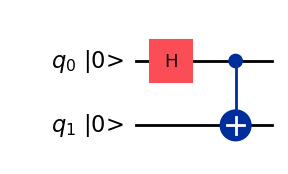

In [1]:
from qiskit import QuantumCircuit

# Create circuit
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.draw('mpl',style="iqp",initial_state=True)

### Simulating the final state
In many situations you want to see the final state of a quantum circuit. We can simulate the Statevector prepared by a quantum circuit using the `quantum_info` package.

In [2]:
import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex

qc = QuantumCircuit(2)
qc.x(0)
qc.h(0)
qc.cx(0, 1)
psi = qi.Statevector.from_instruction(qc)
array_to_latex(psi)
# quiz-time!

<IPython.core.display.Latex object>

### Plotting the state

There are several functions for generating different types of visualization of a quantum state

In [6]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(psi)

MissingOptionalLibraryError: "The 'seaborn' library is required to use 'plot_state_qsphere'. You can install it with 'pip install seaborn'."

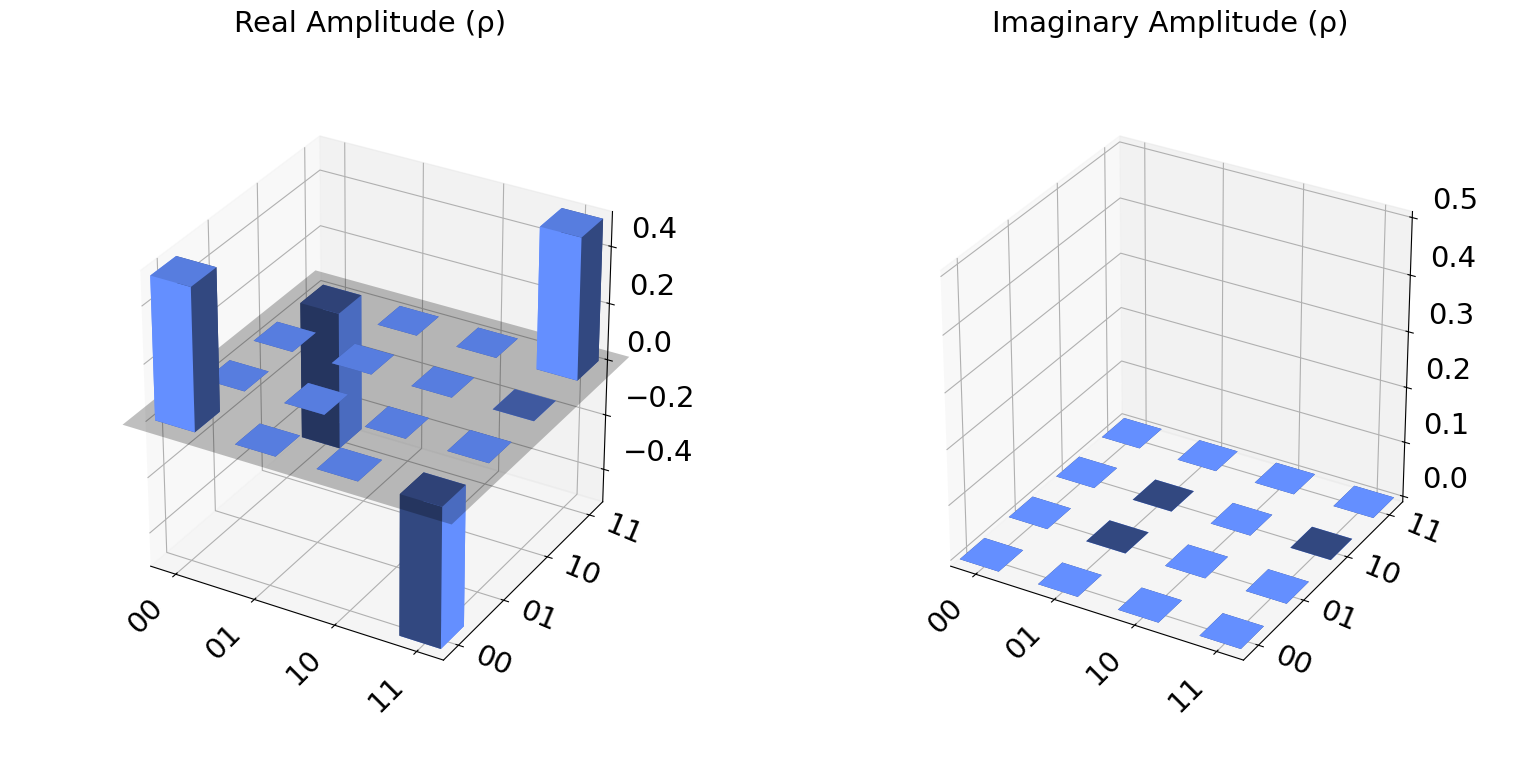

In [7]:
from qiskit.visualization import plot_state_city

plot_state_city(psi)

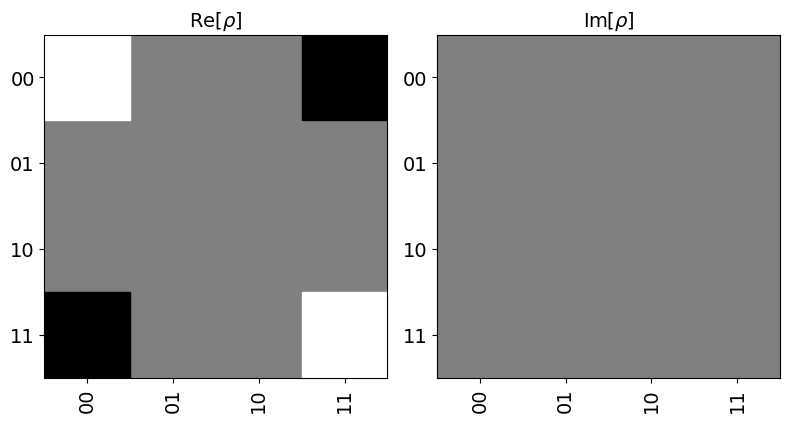

In [8]:
from qiskit.visualization import plot_state_hinton

plot_state_hinton(psi)

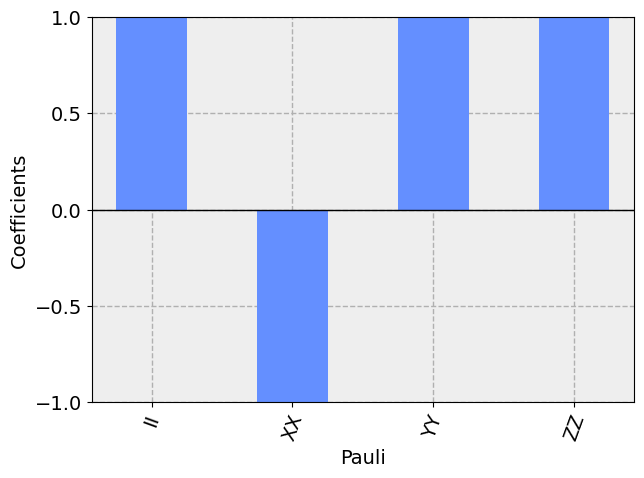

In [9]:
from qiskit.visualization import plot_state_paulivec

plot_state_paulivec(psi)

### Executing the circuit

Before executing the circuit, we need to add a measurement.

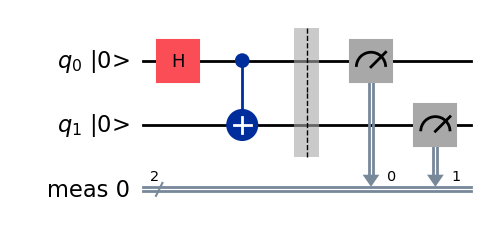

In [10]:
circuit.measure_all()

circuit.draw('mpl',style="iqp",initial_state=True)

To execute a circuit, we need to choose a backend. Here we use the local simulator from qiskit Aer. 

In [11]:
from qiskit_aer import AerSimulator

backend = AerSimulator() # this is the simulator we'll use
job = backend.run(circuit,shots=1000) # this runs the experiment

result = job.result()
counts = result.get_counts()
# quiz-time!

We can then plot the results in a histogram.

In [ ]:
# quiz-time!

### Running on real backends

#### Circuit transpilation

Backends in Qiskit are accessed through `QiskitRuntimeService`. For the duration of this workshop, all participants should have access to the instance given below:

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
# set account here https://quantum.ibm.com/
# service = QiskitRuntimeService(instance="ibm-q-ikerbasque/industry-qiskit-/generic-project")
# when loading your IBM Quantum account for the first time you need to specify your token:
service = QiskitRuntimeService(instance="ibm-q-ikerbasque/industry-qiskit-/generic-project", token="3edd383af4993c47f6dd1d9f5c9471c008a76d3554e76064034c51d10147de6216829e7867bde9c3cca19bc42799b236c2d6a544d42b2e7ba4931bf6ea2cf23a")

ValueError: 'channel' is required if 'token', or 'url' is specified but 'name' is not.

After specifying the instance, we can check which devices we can access with it:

In [14]:
[(b.name, b.configuration().n_qubits) for b in service.backends()]

NameError: name 'service' is not defined

To avoid long times in the queue, let us choose the least busy device:

In [ ]:
from qiskit_ibm_provider import least_busy

backend = service.least_busy(simulator=False, operational=True)
#backend = service.backend("ibm_brisbane")
print(backend)

Before we can submit the circuit to the device, it needs to be _transpiled_ to the backend, i.e., decomposed into operations which the backend can implement. 

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, initial_layout=[0,6], optimization_level=3)
t_qc = pm.run(circuit)

In [ ]:
t_qc.draw('mpl',style="iqp",idle_wires=False)

In [ ]:
from qiskit.visualization import plot_circuit_layout, plot_gate_map
display(plot_circuit_layout(t_qc, backend))

so maybe this was not the best layout choice... let's better let qiskit optimize the layout

In [ ]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t_qc = pm.run(circuit)
t_qc.draw('mpl',style="iqp",idle_wires=False)

Now we can create a sampler object and submit the job

In [ ]:
options = Options()
options.resilience_level = 1
options.optimization_level = 3
 
# Create a Sampler object
sampler = Sampler(backend=backend, options=options)

# Submit the circuit to Sampler
job = sampler.run(t_qc,shots=1000)
print(job.job_id())

In [ ]:
job.status()

As the job is still queued, let's have a look at the results of a previous job I ran:

In [ ]:
# get results
job = service.job('cqcbzgyapgkg008jxcwg')
result = job.result()
counts = result.quasi_dists
plot_histogram(counts)

## 5. Grover's Algorithm

Solves unstructured search problems, e.g. searching an unsorted database with $N=2^n$ elements

Classical computer needs $N/2 = \mathcal{O}(N)$ time, quantum computer $\mathcal{O}(\sqrt{N})$

### Amplitude Amplification
1. Put all items in superposition
2. Apply phase oracle $\tilde{U}_f$
3. Apply diffuser: perform reflection around average amplitude
#### Circuit representation:
<img src="Grovers.png" alt="Drawing" style="width: 580px;"/>

### Amplitude Amplification
<font size="5"> 
    1. Put all items in superposition <br>
    2. Apply phase oracle: flips sign of „winning element“ $|w\rangle$  <br>
    3. Apply diffuser: performs reflection around average amplitude <br>
Repeat 2. & 3. $r$ times $\rightarrow$ final measurement will result in $|w\rangle$ with very high probability.
</font>
<img src="amplitudeamplification.png" alt="Drawing" style="width: 520px;"/>

### Self-made oracle & algorithm
Let us start by creating our own phase oracle function and diffuser function.

In [ ]:
from qiskit.quantum_info import Operator

def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

def diffuser(n):
    qc = QuantumCircuit(n, name='Diff')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    return qc

Now we can combine these to build our Grover algorithm:

In [ ]:
def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n,marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

In [ ]:
import numpy as np

n = 5
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n, marked)

qc.draw('mpl',style="iqp",initial_state=True)

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend = AerSimulator()
tqc = transpile(qc, backend)

result = backend.run(tqc, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts) 
# quiz-time!

In [ ]:
def Grover_run_roundwise(n, marked):
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    counts = []
    for i in range(r):
        qc = QuantumCircuit(n, n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n,marked), range(n))
            qc.append(diffuser(n), range(n))
        qc.measure(range(n), range(n))
        tqc = transpile(qc, backend)
        result = backend.run(tqc, shots=10000).result()
        counts.append(result.get_counts())
    return counts

backend = AerSimulator()
counts = Grover_run_roundwise(n,marked) 
# quiz-time!

In [ ]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y==x:
    y = np.random.randint(2**n)
marked = [x,y]
qc = Grover(n, marked)

backend = service.least_busy(simulator=False, operational=True)
print("least busy backend: ", backend)
#backend = provider.get_backend('ibm_osaka')

shots = 10000
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
tqc = pm.run(qc)
job = sampler.run(tqc,shots=1000)
print(job.job_id())

In [ ]:
old_job = service.job('cqcc09sqgrzg008cw7ng')
results = old_job.result()
counts = results.quasi_dists
plot_histogram(counts)

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.
<br>
<br>
<br>
<br>
<br>
<br>

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.

ii) Alice and Charlie are married, so if you invite one of them, you have to invite the other one as well.
<br>
<br>
<br>
<br>

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.

ii) Alice and Charlie are married, so if you invite one of them, you have to invite the other one as well.

iii) In order to liven up the atmosphere, you want to invite at least one of your more entertaining friends, Bob and Dave.

iv) Whenever the three guys, Bob, Charlie and Dave, get together, they somehow incite each other and the party might get out of control. So don't invite all three of them.

v) You know that if you invite Bob, he will most likely ask Alice about ideas for a birthday present. Therefore, if you invite Bob, you should also invite Alice (but not necessarily the other way around).

vi) Dave will only come if Bob comes as well (not the other way around though). So no point to invite him if Bob is not getting invited.

Let us use Grover's algorithm to figure out which options you have for possible invite lists. To feed these requirements into the oracle, let us encode them as logical statements and then formulate them as a 3-SAT problem. 

Note that 3-SAT problems can be always written in what is known as conjunctive normal form (CNF), which is a conjunction of clauses (or a single clause). Each clause in the 3-SAT problem is a disjunction ("or") of at most three literals. A literal is either a variable, called positive literal, or the negation of a variable, called negative literal.

To give you an example, the first statement could be encoded as a logical statement as $\lnot (A \land E)$. 

However, this is not a clause (or a conjunction of clauses). We can rewrite it as $\lnot A \lor \lnot E$
though, which is a disjunction of two negative literals and therefore a valid clause.

For the input to the oracle in Qiskit, we encode each clause as one line with the literals and a "0" in the end, so in this case the corresponding line would be (encoding A as 1, B as 2, C as 3, D as 4 and E as 5),

-1 -5 0

Writing each of the restrictions as a clause or a conjunction of clauses, we get for the six restrictions the following seven clauses as ii) cannot be written as a single clause:

i) $\quad \lnot A \lor \lnot E \qquad$ -1 -5 0

ii) $\quad (A \lor \lnot C) \land (\lnot A \lor C) \qquad$ 1 -3 0 $\land$ -1 3 0

iii) $\quad B \lor D \qquad$ 2 4 0

iv) $\quad \lnot B \lor \lnot C \lor \lnot D \qquad$ -2 -3 -4 0

v) $\quad A \lor \lnot B \qquad$ 1 -2 0

vi) $\quad B \lor \lnot D \qquad$ 2 -4 0

In [ ]:
from qiskit.circuit.library import PhaseOracle

# this indicates that the input is CNF with five variables and seven clauses
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 5 7 
-1 -5 0
1 -3 0
-1 3 0
2 4 0
-2 -3 -4 0
1 -2 0
2 -4 0
'''

with open("3sat.dimacs", "w") as text_file:
    text_file.write(input_3sat)

oracle = PhaseOracle.from_dimacs_file("3sat.dimacs")

In [ ]:
from qiskit_algorithms import Grover, AmplificationProblem
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler
import warnings
#warnings.filterwarnings('ignore')

problem = AmplificationProblem(oracle=oracle)

# Use Grover's algorithm to solve the problem
grover = Grover(sampler = Sampler())
result = grover.amplify(problem)
result.top_measurement

In [ ]:
plot_histogram(result.circuit_results) 
# quiz-time!

In [ ]:
# transpile the circuit for our backend
qc = grover.construct_circuit(problem, max(result.iterations))
qc.measure_all()
backend = service.backend("ibm_osaka")
grover_compiled = transpile(qc, backend=backend, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

Unfortunately, the depth and number of gates needed scales up very quickly and is for useful problems above the limits regarding decoherence time of current near-term quantum computers. Thus, for now we will stick to the simulations ;-)

## 6. Noisy backends and measurement error mitigation

Present day quantum computers are subject to noise of various kinds. We can use different error suppression and error mitigation methods to reduce it.

- Error suppression: reduces errors by modifying the circuit
- Error mitigation: reduces the effects from a specific source of error by classically post-processing the counts to produce more accurate expectation values.

### Error suppression: Layout Choice

As we can see here from the connectivity map with calibration data of the device *ibm_osaka*, not all qubits and connections are equally good, so it makes sense to optimize the layout. (quiz-time!)
<img src="calibration_data_osaka.png" alt="Drawing" style="width: 500px;"/>

### Error suppression: Dynamical Decoupling (DD)

Insert periodic sequences of X/Y pulses to suppress decoherence and unwanted ZZ interactions by "averaging it out".
<img src="DynamicalDecoupling.png" alt="Drawing" style="width: 580px;"/>

### Error Mitigation: Zero-Noise Extrapolation (ZNE)

Compute the expectation value of an observable for different noise factors (amplification stage) and then use the measured expectation values to infer the ideal expectation value at the zero-noise limit (extrapolation stage).
<img src="ZNE.png" alt="Drawing" style="width: 500px;"/>

### Error Mitigation: Measurement error mitigation
We start by creating a set of circuits that prepare and measure each of the $2^n$ basis states, where $n$ is the number of qubits. The outcome statistics are then captured by a calibration matrix $M$, where the element $M_{ij}$ gives the probability to get output state $|i\rangle$ when state $|j\rangle$ was prepared. 

Plotting such a calibration matrix can look like this (quiz-time!!):
<img src="mem.png" alt="Drawing" style="width: 480px;"/>

Note that the calibration matrix is in general not invertible, thus requiring a generalized inverse method to solve.  Additionally, the noise is not deterministic, and has fluctuations, so this will in general not give you the ideal noise-free state, but it should bring you closer to it.

Choosing better qubits results in smaller off-diagonal elements:
<img src="mem2.png" alt="Drawing" style="width: 480px;"/>

Let us check the effect of that on the results of a quantum circuit. As an example, we prepare a GHZ state:

In [ ]:
from qiskit import QuantumCircuit, transpile

# GHZ state
n = 3
qc = QuantumCircuit(n, n)
qc.h(1)
qc.cx(1, 0)
qc.cx(1, 2)
qc.measure(range(n), range(n))
layout = [0,14,18]
pm = generate_preset_pass_manager(backend=backend, initial_layout=layout, optimization_level=3)
t_qc = pm.run(qc)

Using the Sampler, we can choose in the options the resilience level (1: with mem, 0: no mem)!

In [ ]:
from qiskit_ibm_runtime import Sampler
options.resilience_level = 1
sampler = Sampler(backend=backend,options=options)
#job = sampler.run(t_qc, shots=shots)
#print(job.job_id())

In [ ]:
options.resilience_level = 0
sampler = Sampler(backend=backend,options=options)
#job = sampler.run(t_qc, shots=shots)
#print(job.job_id())

In [ ]:
ghz_mem = service.job('cqdryehfejeg0085wt00') # [0,14,18]
ghz_nomem = service.job('cqdryfsgtagg008qr8s0')
results = ghz_nomem.result()
counts_nomem = results.quasi_dists
results = ghz_mem.result()
counts_mem = results.quasi_dists
plot_histogram([counts_nomem[0],counts_mem[0]], legend=['noisy', 'mitigated'])
# quiz-time!

In [ ]:
print(counts_nomem[0])
print(counts_mem[0])

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table